<h1 style="color:#032652 ; font-family:'Times New Roman' "> Email Phishing Detection and Classification </h1>

<h2 style="background:#F6FAFF; color:#053573 ; font-family:'Times New Roman' "> <br>  General Overview and Purpose <br> </h2>

Email phishing poses a significant cyber threat, exploiting human vulnerabilities to deceive recipients into divulging sensitive information or performing unauthorized transactions. Addressing this challenge, this project explores the efficacy of deep learning methodologies in detecting and classifying phishing emails.

<h2 style="background:#F6FAFF; color:#053573 ; font-family:'Times New Roman'"> <br>  Data Cleaning and Exploratory Data Analysis <br>
</h2>

> <p style=" color:#032652 ; font-family:'Times New Roman'; font-size: 18px ;text-align: justify "> Loading libraries and data </p>

In [1]:
# Data Analysis and Manipulation libraries
import numpy as np
import pandas as pd

# Data Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from collections import Counter
from wordcloud import WordCloud

# Statistical Analysis libraries
from scipy.stats import skew, kurtosis, zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Data Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams
import re
import string


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nmeliksetyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nmeliksetyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
emails_data = pd.read_csv('emailsdataset1.csv',encoding='latin-1')
emails_data.head()

,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


> <p style=" color:#032652 ; font-family:'Times New Roman'; font-size: 18px ;text-align: justify "> Understanding the data </p>

The dataset contains two columns, text represents the subject of the email, and label represents the phishing state, with 1 indicating that the email is a phishing, 0 indicating that the email is legitimate.

In [3]:
print(emails_data.isnull().sum())

label    0
text     0
dtype: int64


In [4]:
print("Number of emails in the dataset:", len(emails_data))

Number of emails in the dataset: 83448


There are 83448 emails in this dataset. It is collected from https://zenodo.org/records/8339691 source which contains 11 different sources. 

In [5]:
#Preparing to Plot the distribution 
value_counts = emails_data['label'].value_counts()
total_samples = len(emails_data)
labels = value_counts.index.tolist()
colors = ["#5C8DBC", "#9B59B6"] 

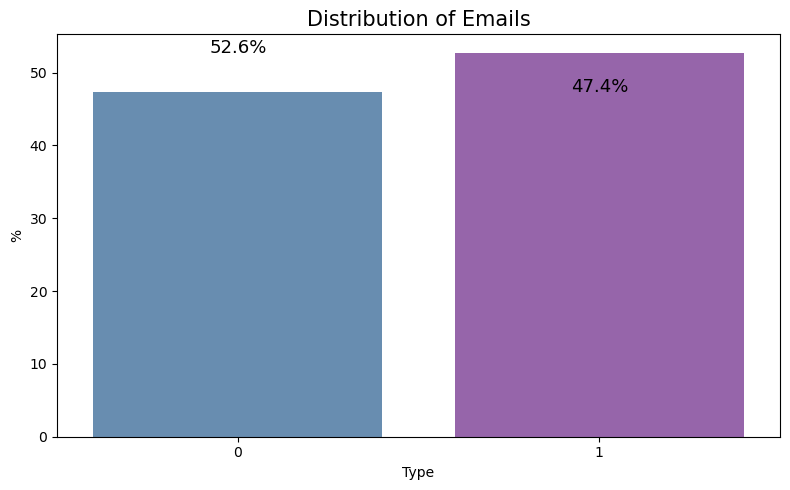

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))

percentage_values = value_counts / total_samples * 100
sns.barplot(x=labels, y=percentage_values, ax=ax, palette=colors)
for i, v in enumerate(percentage_values):
    ax.text(i, v, f'{v:.1f}%', fontsize=13)
    
ax.set_ylabel("%")
ax.set_xlabel("Type")
plt.title('Distribution of Emails', fontsize=15)

plt.tight_layout()
plt.show()

The graph illustrates that 52.6% of the emails are categorized as phishing, whereas 47.4% are categorized as authentic. This almost equal distribution suggests a well-balanced dataset across both classifications, a favorable scenario for training models as it mitigates the potential bias towards any specific class.

> <p style=" color:#032652 ; font-family:'Times New Roman'; font-size: 18px ;text-align: justify "> Cleaning the data </p>


The process will consists of several important steps, which will make sure that the data we'll give as input to our models will be of good quality for model training and testing. 

1. Making all emails lowercase
2. Removing the stopwords like a, an, and, are, as, at, be, etc.
3. Removing punctuation signs, special characters
4. Removing non-alphanumeric characters and one-length words 

In [7]:
emails_data['text'] = emails_data['text'].str.lower()

### Removing Stopwords

In [8]:
common_words = set(stopwords.words('english'))

In [9]:
def eliminate_common_words(words):
    return [word for word in words if word not in common_words]

In [10]:
emails_data['text'] = emails_data['text'].apply(lambda x: ' '.join([w for w in word_tokenize(x) if w not in common_words]))

### Removing Signs and Special Characters

In [11]:
def eliminate_special_chars(word):
    return word.translate(str.maketrans('', '', string.punctuation))

In [12]:
emails_data['text'] = emails_data['text'].apply(eliminate_special_chars)

In [13]:
def remove_non_english(text):
    # Remove non-English letters and numbers using regular expression
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    return cleaned_text

emails_data['text'] = emails_data['text'].apply(remove_non_english)


In [14]:
def clean_text(text):
    # Remove words containing "escape" and filter out one-length words
    words = [word for word in text.split() if "escape" not in word and len(word.strip()) > 1]
    
    # Rejoin the modified words into a single string
    return ' '.join(words)


In [16]:
emails_data['text'] = emails_data['text'].apply(clean_text)

### Displaying Emails from the dataset

In [17]:
# Function to display email content
def display_email_content(label, index, df):
    print(f"Email Number {index}")
    email_content = df[df['label'] == label]['text'].iloc[index]
    print(email_content + "\n")

In [ ]:
# Display some legitimate emails
for i in range(1, 4):
    display_email_content(0, i, emails_data)

In [ ]:
# Display some bad emails
for i in range(1, 4):
    display_email_content(1, i, emails_data)

### Understanding common words and patterns in a dataset

In [20]:
spam_emails = emails_data[emails_data['label'] == 1]['text']
legitimate_emails = emails_data[emails_data['label'] == 0]['text']

In [21]:
spam_words = Counter()
spam_emails.apply(lambda x: spam_words.update(x.split()))

legitimate_words = Counter()
legitimate_emails.apply(lambda x: legitimate_words.update(x.split()))


In [ ]:
s_common = spam_words.most_common(10)
l_common = legitimate_words.most_common(10)

In [ ]:
s_common_df = pd.DataFrame(s_common, columns=['Word', 'Frequency'])
l_common_df = pd.DataFrame(l_common, columns=['Word', 'Frequency'])

In [22]:
def plot_most_common_words(words_common, title, color):
    plt.figure(figsize=(15, 5))
    plt.bar(words_common['Word'], words_common['Frequency'], color=color)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()


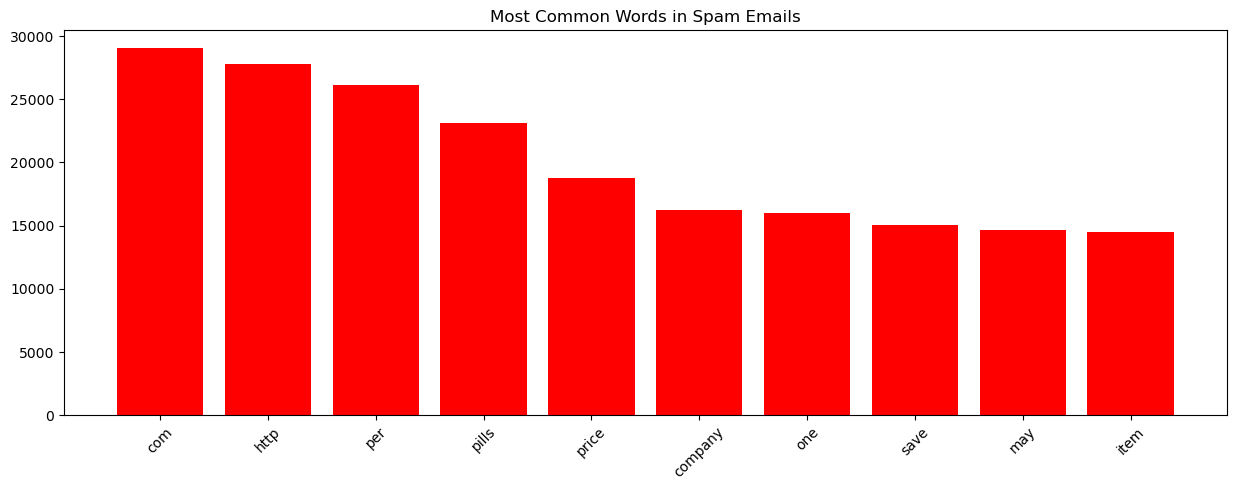

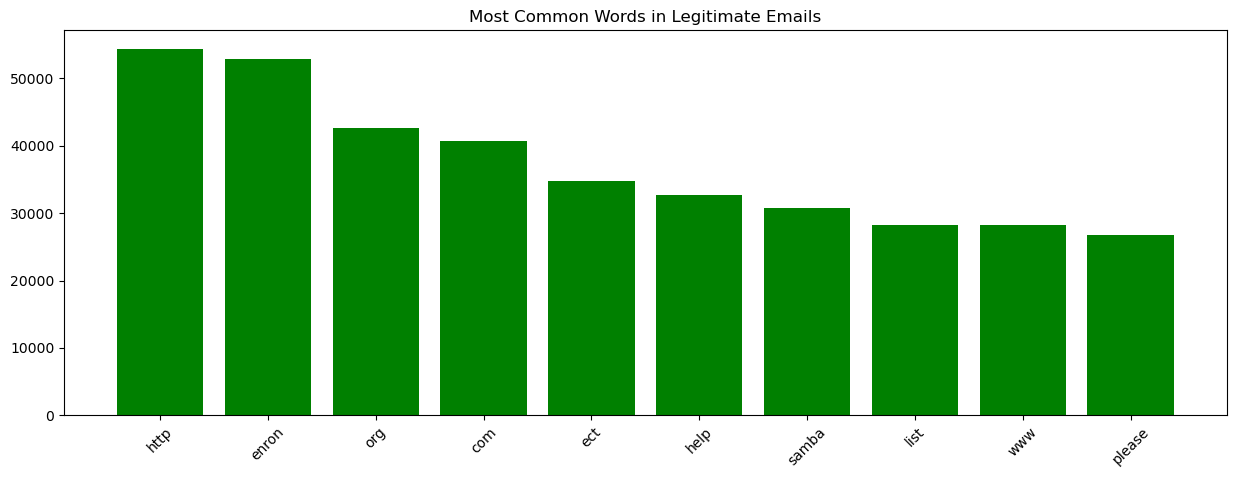

In [23]:
plot_most_common_words(s_common_df, 'Most Common Words in Spam Emails', 'red')
plot_most_common_words(l_common_df, 'Most Common Words in Legitimate Emails', 'green')


In [ ]:
spam_wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(' '.join(spam_emails))

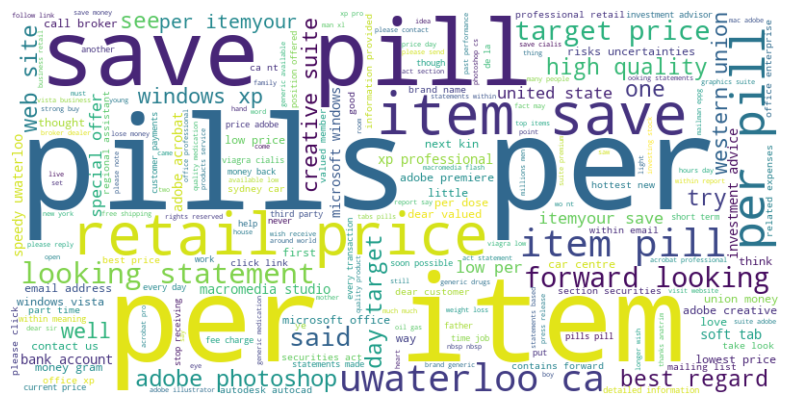

In [24]:
plt.figure(figsize=(12, 7))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
legitimateemails = WordCloud(width=1000, height=600, background_color='white').generate(' '.join(legitimate_emails))


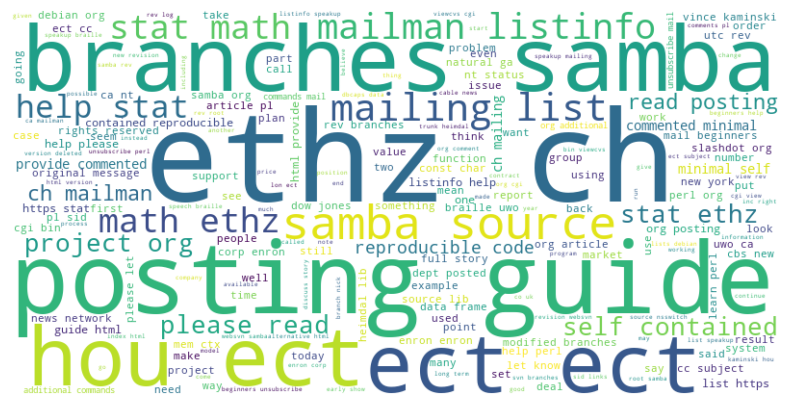

In [25]:
plt.figure(figsize=(12, 7))
plt.imshow(legitimateemails, interpolation='bilinear')
plt.show()

In [27]:
emails_data.to_csv("cleaned_data.csv")